# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

/Users/majapedigo/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### 1b. Explore the data

In [3]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

/Users/majapedigo/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [5]:
#your turn
# Merge the transactions and offers dataset on "order_id"
df_merged=pd.merge(df_transactions,df_offers,on='offer_id')
df_merged.head()



,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,1,January,Pinot Noir,72,17,France,False
1,Rodriguez,2,1,January,Pinot Noir,72,17,France,False
2,Martin,2,1,January,Pinot Noir,72,17,France,False
3,Jackson,2,1,January,Pinot Noir,72,17,France,False
4,Campbell,2,1,January,Pinot Noir,72,17,France,False


In [6]:
# Create a new dataframe  with pivot table and replace the "Nan"s with 0's


df_new=pd.pivot_table(df_merged, index='customer_name',
                      columns='offer_id',values='n',fill_value=0)
# Reset index 
#df_new=df_new.reset_index(drop=False)

# Display first 5 
df_new.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [10]:
x_cols= df_new.iloc[:,1:].values
x_cols


array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]])

Write code that applies the KMeans clustering method from scikit-learn to this matrix.


In [11]:
# Import KMeans
from sklearn.cluster import KMeans

kr=range(2,11)
inertias=[]

for i in kr:
    
    # Create a KMeans instance with k clusters: model
    model=KMeans(n_clusters=i)
    
    # Fit model to samples
    model.fit(x_cols)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)


Construct a plot showing 𝑆𝑆 for each 𝐾 and pick 𝐾 using this plot. For simplicity, test 2≤𝐾≤10


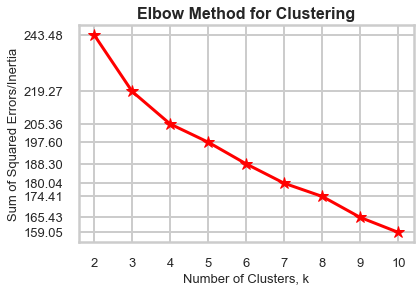

In [12]:
# Plot kr and inetias
           
plt.plot(kr,inertias,'-*',color='red')
plt.xlabel('Number of Clusters, k', fontsize=13)
plt.ylabel('Sum of Squared Errors/Inertia', fontsize=13)
plt.title('Elbow Method for Clustering',fontsize=16,fontweight='bold')
plt.xticks(kr,fontsize=13)
plt.yticks(inertias,fontsize=13)
plt.show()


The elbow point is the point at which the plot starts descending much more slowly.

When the model is fit with 4 clusters, we can see a line annotating the “elbow” in the graph, which in this case we know to be the optimal number.



Make a bar chart showing the number of points in each cluster for k-means under the best 𝐾.


In [13]:
# Create a KMeans model with 4 clusters : model

model = KMeans (n_clusters=4, random_state=21)

# Use fit_predict to fit model and obtain cluster labels: labels

labels= model.fit_predict(x_cols)

# Display the cluster labels
print(labels)


[1 3 2 1 3 3 2 1 3 1 3 2 1 3 3 2 3 2 1 3 1 3 3 3 2 3 3 3 3 2 3 3 3 0 1 1 3
 1 3 1 2 2 3 0 1 0 1 3 3 3 3 0 3 2 0 1 2 3 1 3 3 3 3 1 1 2 2 3 3 3 3 3 0 1
 3 1 2 3 3 2 0 0 3 2 1 1 1 3 3 3 0 1 3 1 3 3 1 3 0 0]


/Users/majapedigo/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


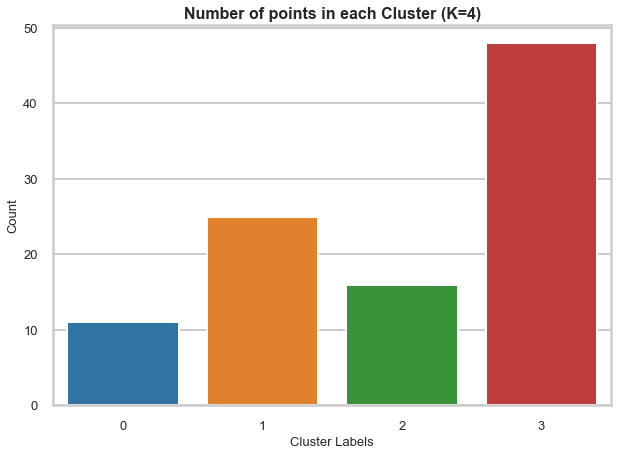

In [14]:
# Create a Bar chart showing the number of points in each clusters
plt.figure(figsize=(10,7))
sns.countplot(labels)
plt.xlabel('Cluster Labels',fontsize=13)
plt.ylabel('Count',fontsize=13)
plt.title('Number of points in each Cluster (K=4)',fontsize=16,fontweight='bold')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [15]:
# Alternative way:

# # import Counter
from collections import Counter

# # print the count of each labels
print(Counter(model.labels_))

Counter({3: 48, 1: 25, 2: 16, 0: 11})


What challenges did you experience using the Elbow method to pick 𝐾 ?

The elbow point is the point at which the plot starts descending much more slowly. However, in our dataset, it was difficult to differantiate the "elbow".

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For K = 2, the average silhouette score is: 0.0947
For K = 3, the average silhouette score is: 0.1192
For K = 4, the average silhouette score is: 0.1357
For K = 5, the average silhouette score is: 0.1437
For K = 6, the average silhouette score is: 0.1431
For K = 7, the average silhouette score is: 0.1247
For K = 8, the average silhouette score is: 0.1278
For K = 9, the average silhouette score is: 0.1180
For K = 10, the average silhouette score is: 0.1426


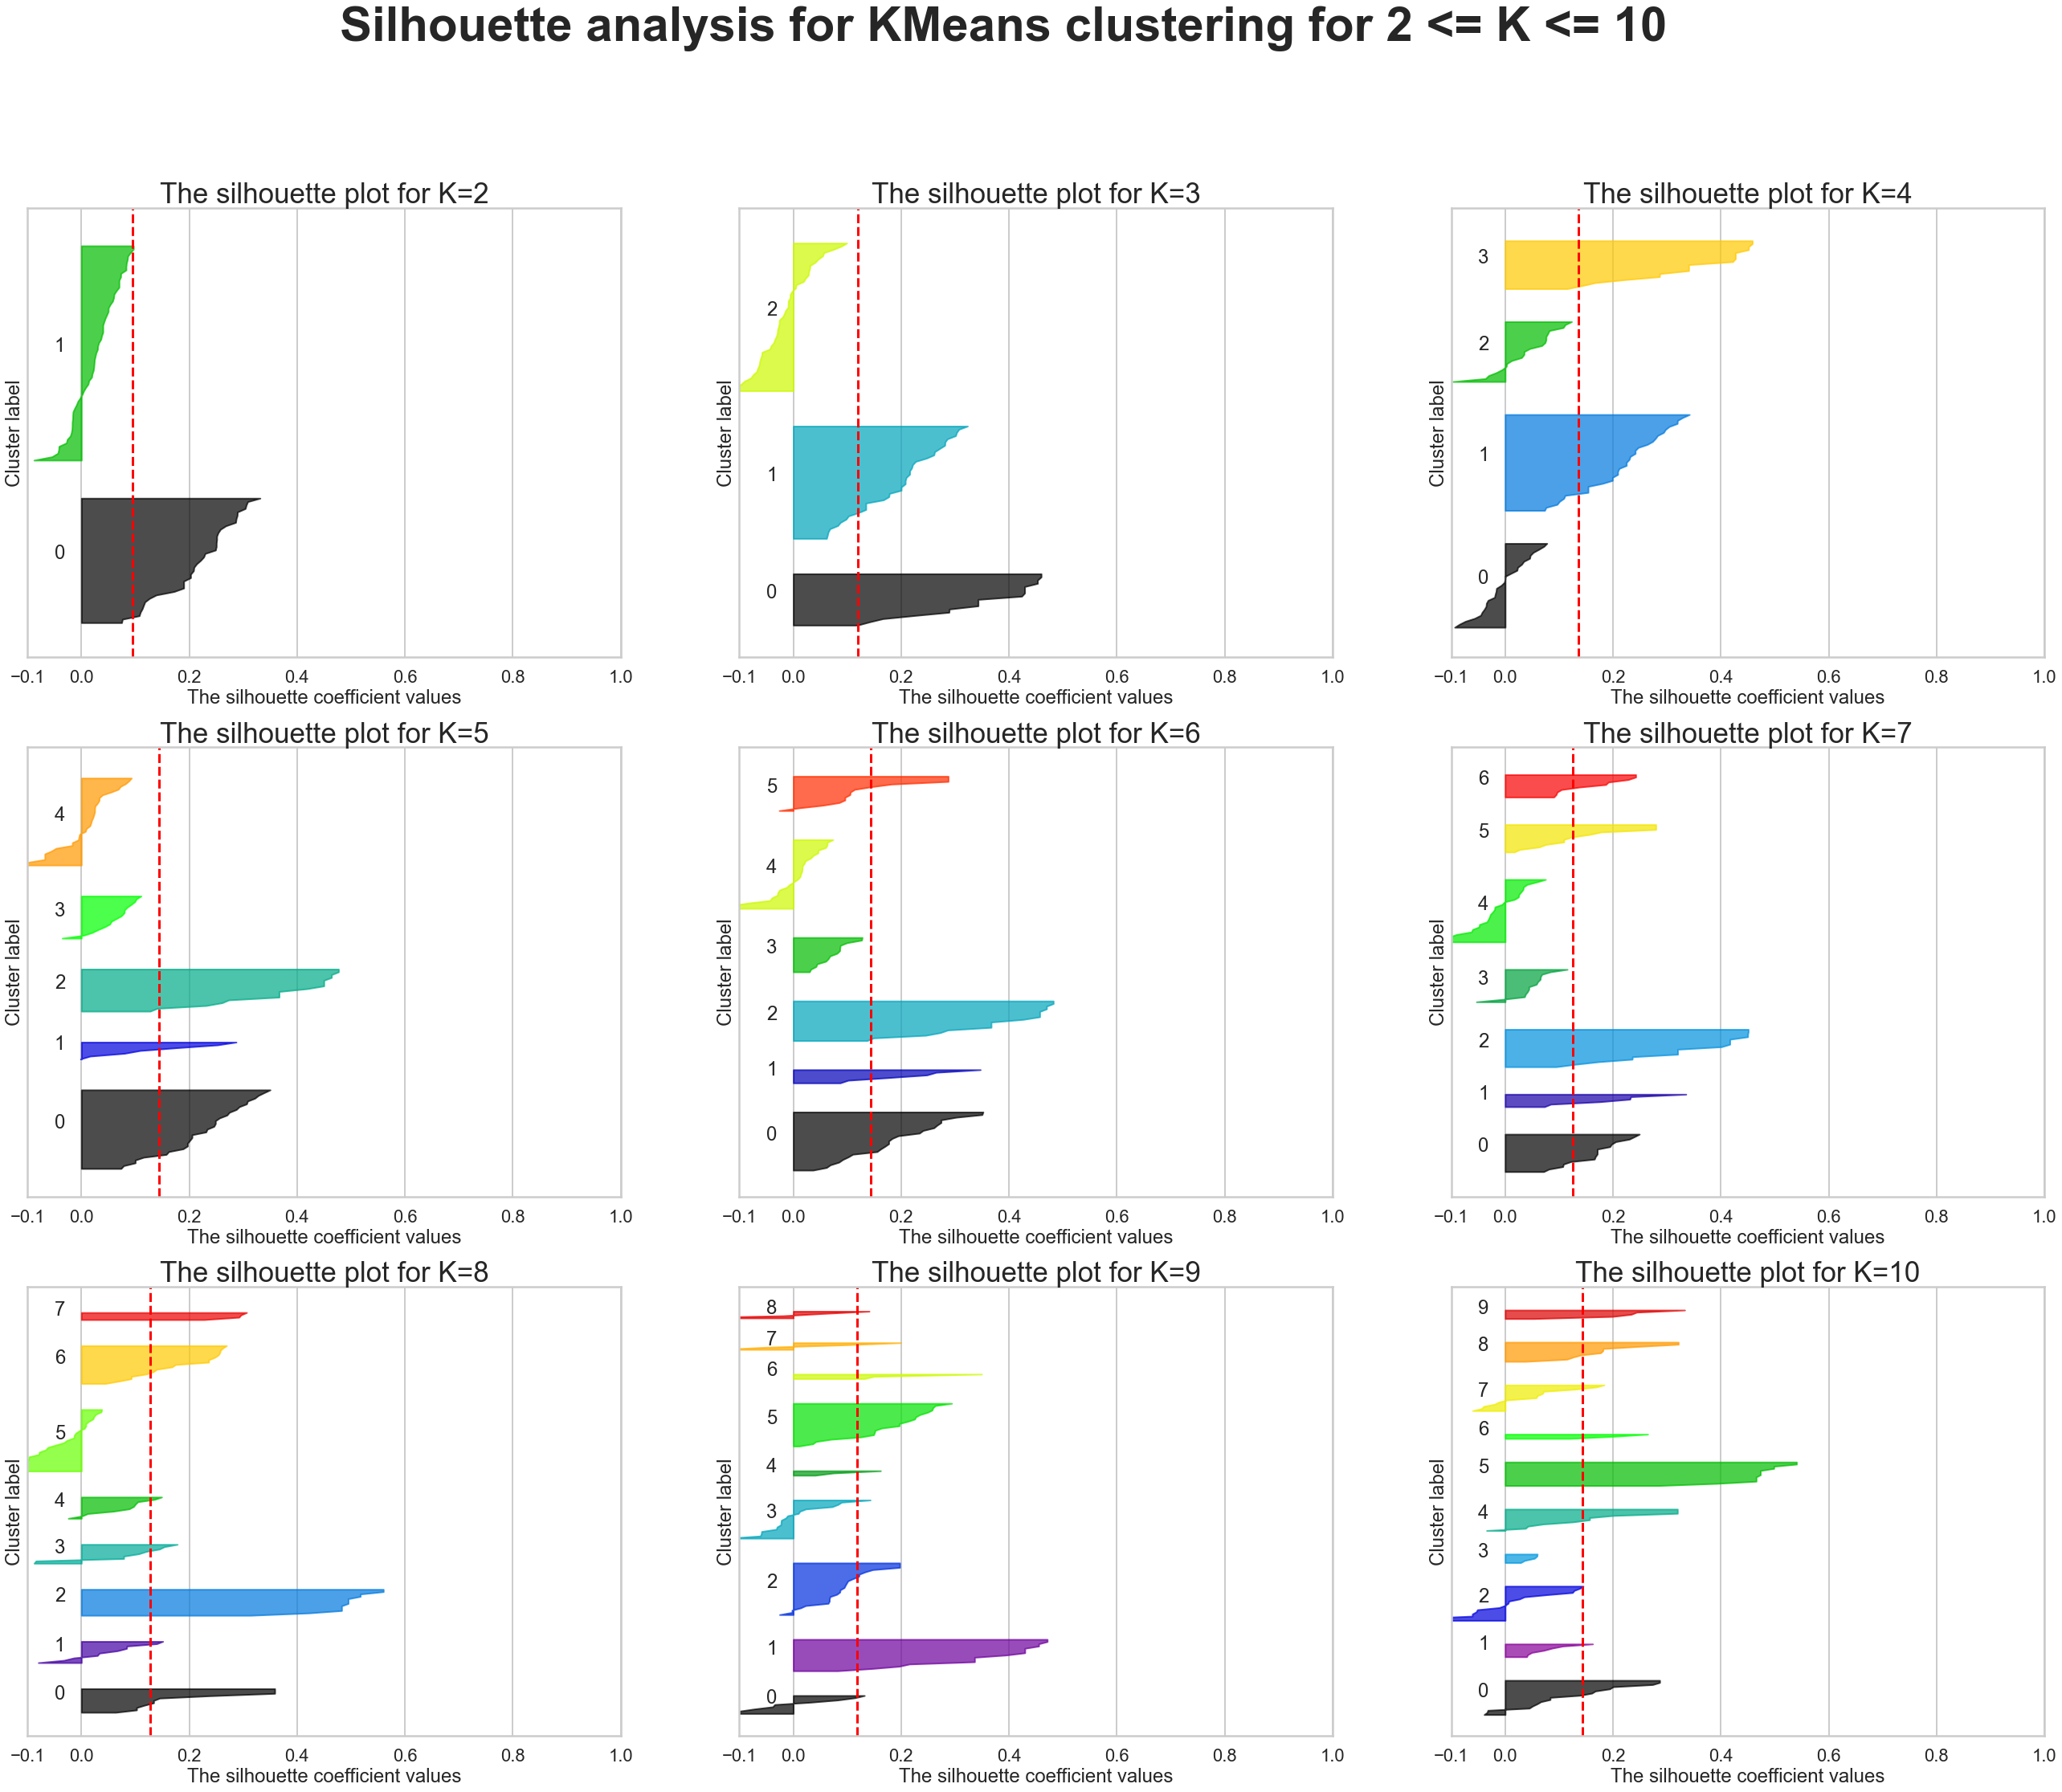

In [17]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

range_n_clusters = list(range(2,11))
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(45, 35)

silhouette_avg_scores = [] # empty array to plot silhouette scores later

for idx, n_clusters in enumerate(range_n_clusters):
    x_axes = idx // 3
    y_axes = idx % 3
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax[x_axes][y_axes].set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax[x_axes][y_axes].set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    print("For K = {}, the average silhouette score is: {:0.4f}".format(n_clusters, silhouette_avg))

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)



    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax[x_axes][y_axes].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax[x_axes][y_axes].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax[x_axes][y_axes].set_title("The silhouette plot for K={}".format(n_clusters), fontsize=35)
    ax[x_axes][y_axes].set_xlabel("The silhouette coefficient values")
    ax[x_axes][y_axes].set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax[x_axes][y_axes].axvline(x=silhouette_avg, color="red", linestyle="--")

    ax[x_axes][y_axes].set_yticks([])  # Clear the yaxis labels / ticks
    ax[x_axes][y_axes].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering for 2 <= K <= 10"),
                 fontsize=60, fontweight='bold')
    
    
    
    
    
      # # # --------- # # # --------- # # # --------- # # # 
    # # 2nd Plot showing the actual clusters formed # # 
    
    # # # Realized original x_cols is not a 2D data (its 32-D due to 32 different orders)
    # # Thus can't do a scatter plot! 
    
#     colors = cm.nipy_spectral(K_pred.astype(float) / k)
# #     ax2.scatter(x_cols[:, 6], x_cols[:, 1], marker='.', s=50, lw=0, alpha=0.7,
# #                 c=colors, edgecolor='k')

#     centers = K_cluster.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')
    
#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=0.5,
#                     s=30, edgecolor='k')
        
#     ax2.set_title("The visualization of the clustered data.")
#     ax2.set_xlabel("Feature space for the 1st feature")
#     ax2.set_ylabel("Feature space for the 2nd feature")


plt.savefig('The Silhouette coefficient values plot.png')
plt.show()


##### Compute the average silhouette score for each  𝐾  and plot it. What  𝐾  does the plot suggest we should choose? Does it differ from what we found using the Elbow method?

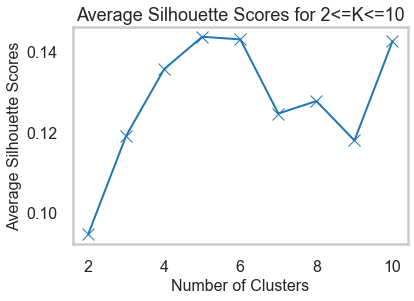

In [18]:
plt.plot(range(2,11), silhouette_avg_scores, linewidth=2, marker='x')
plt.xlabel("Number of Clusters", fontsize=16)
plt.ylabel("Average Silhouette Scores", fontsize=16)
plt.title("Average Silhouette Scores for 2<=K<=10", fontsize=18)
plt.grid(False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

From the plot above, we should choose K=9 because it has the highest silhouette score.



#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [19]:
# Import necessary library

from sklearn.decomposition import PCA


# Create a PCA sample : pca
pca = PCA(n_components=2)

# Fit the Pca sample to the dataset
pca.fit(x_cols)

# Transform the dataset  
pca_features = pca.transform(x_cols)

# Print the shape of pca_features
print(pca_features.shape)

(100, 2)


/Users/majapedigo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexes/base.py:4307: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


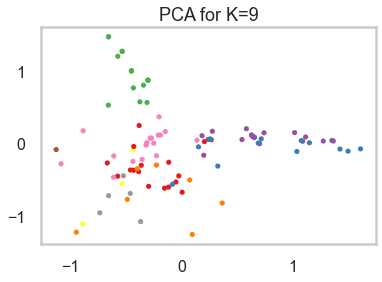

In [20]:
# label these pca_feature as 'x'and 'y'
x , y = zip(*pca_features) #or x = pca_features[:,0]     # -----> first column 
                            #  y = pca_features[:,1]     # -----> second column



# Get the clusters for customers (n_clusters=9 from the silhouette plot above)
clusters = KMeans(n_clusters=9, random_state=21)
df_new['cluster_9'] = clusters.fit_predict(x_cols)


# add customer name, x and y to the df that we just created above
df_new['x'] = x
df_new['y'] = y

item_columns = df_new.columns[[range(32)]]
df_new = df_new.drop(item_columns,axis=1)

# Plot a scatterplot of the `x` vs `y` columns
plt.scatter(df_new['x'], df_new['y'], c = df_new['cluster_9'], 
            cmap='Set1', s = 10)
plt.grid(False) 
plt.title("PCA for K=9", fontsize=18) 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

After we performed PCA and reduced the dimensionality of our data from 32 to 2, a scatter plot were created for K=9 which was chosed based on the silhouette metrics. According to this scatter plot, there are no clear boundaries between the clusters for K=9. Let's try different K values to find the optimal number of clusters.

In [21]:
df = df_new.drop(['cluster_9'],axis=1).copy()
#df=df.reset_index(drop=False)
df.head()

offer_id,x,y
customer_name,,
Adams,1.014908,0.157764
Allen,-0.313043,0.019268
Anderson,-0.451462,1.008114
Bailey,0.700551,0.006002
Baker,0.072574,-0.494352


In [22]:
# Cluster predictions for different K values 
kr = list(range(2, 11))

for k in kr:
    k_means = KMeans(n_clusters=k, random_state=21)
    k_pred = k_means.fit_predict(x_cols)
    df['Cluster_' + str(k)] = k_pred

df.head(3)

offer_id,x,y,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10
customer_name,,,,,,,,,,,
Adams,1.014908,0.157764,1,2,1,3,5,1,0,3,2
Allen,-0.313043,0.019268,0,0,3,1,4,5,2,7,6
Anderson,-0.451462,1.008114,0,1,2,4,0,4,6,2,1


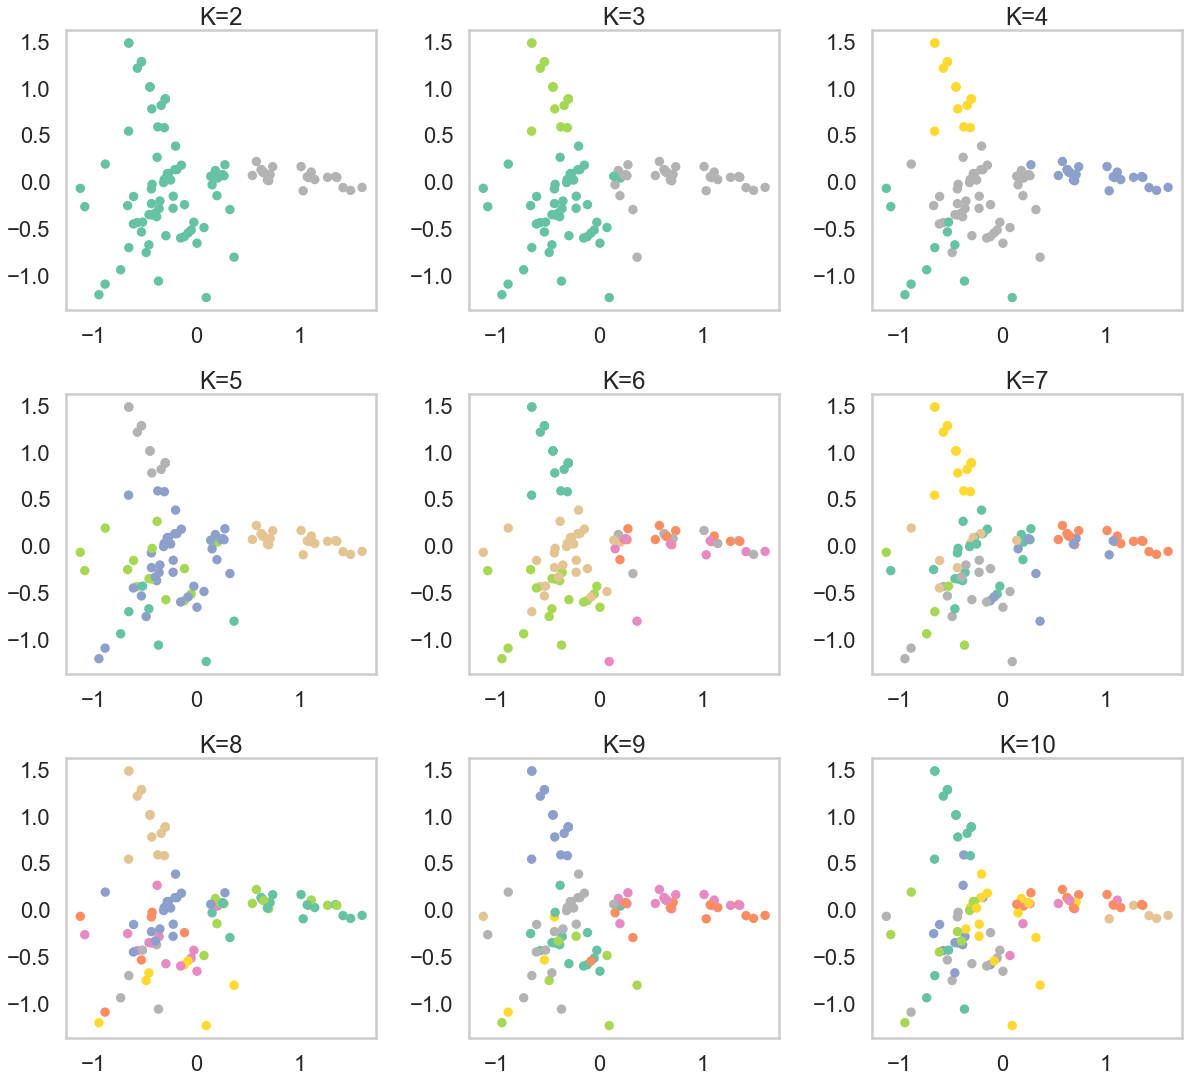

In [23]:
# Produce subplots for clusters 
kr = list(range(2,11))

len_array = len(kr)

fig,axes = plt.subplots( len_array//3 + len_array%3, 3)
fig.set_size_inches(20,16)
fig.subplots_adjust(top=1,wspace=0.3,hspace=0.3)

for idx,k in enumerate(kr):
    x_axes = idx//3
    y_axes = idx%3
    
    axes[x_axes][y_axes].scatter(df['x'],df['y'],c=df['Cluster_'+str(k)],cmap='Set2',s=55)
    axes[x_axes][y_axes].grid(False)
    axes[x_axes][y_axes].set_title('K='+str(k))
    
    
    
plt.show()

###### K=3 appears to cluster the PCA transformed data the best, as there seems to be little or none misclassfification.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

###### Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?

In [24]:
# Reset index 
df=df.reset_index(drop=False)

# Extract the relevant columns
df1 = df[['customer_name','Cluster_3','Cluster_9']]

# Merge two dataframe
df_merge_final=pd.merge(df1 ,df_merged,on='customer_name')

# Display the head
df_merge_final.head()


,customer_name,Cluster_3,Cluster_9,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
0,Adams,2,3,18,1,July,Espumante,6,50,Oregon,False
1,Adams,2,3,29,1,November,Pinot Grigio,6,87,France,False
2,Adams,2,3,30,1,December,Malbec,6,54,France,False
3,Allen,0,7,9,1,April,Chardonnay,144,57,Chile,False
4,Allen,0,7,27,1,October,Champagne,72,88,New Zealand,False


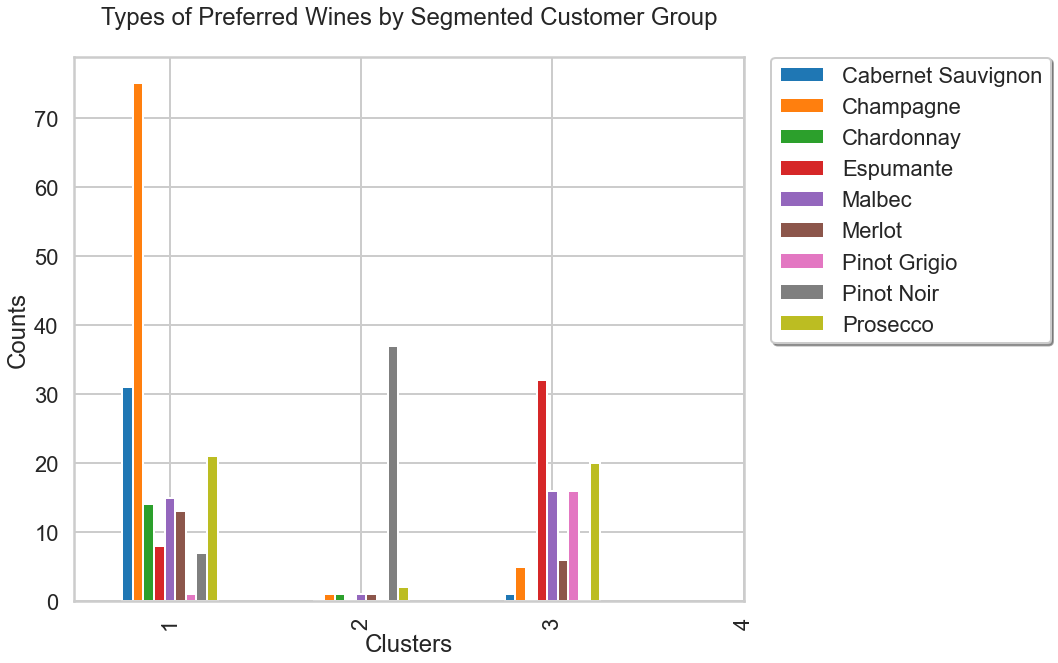

In [25]:
# Cross-tabulation of  Cluster_4  and varietal columns
crosstab = pd.crosstab(df_merge_final['Cluster_3'],df_merge_final['varietal'])

# Display plot
crosstab.plot(kind='bar', figsize=(12,10))
plt.xlabel("Clusters")
plt.ylabel("Counts")
plt.xticks(range(4),('1','2','3','4'))
plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1.02),
          ncol=1, fancybox=True, shadow=True)
plt.title("Types of Preferred Wines by Segmented Customer Group", y=1.05 )
plt.show()

The bar plot was produced for K=3. According to this bar plot, customers belong to the group 3 mostly like "Pinot Noir" than any other wine types. Customers clustered on the group 2 like "Champagne" the most with a great difference than any other wine types.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

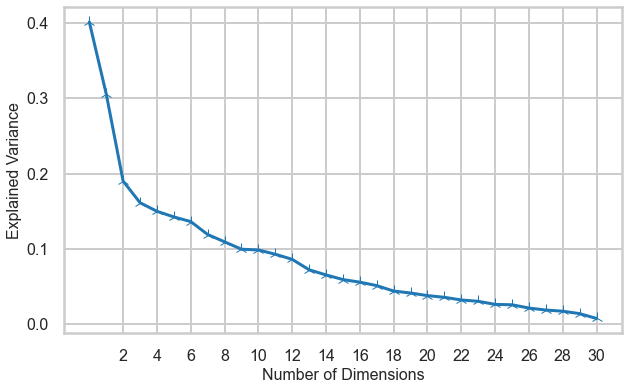

In [26]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)
plt.figure(figsize=(10,6))
plt.plot(pca.explained_variance_, marker='2')
plt.xlabel('Number of Dimensions', fontsize=16)
plt.ylabel('Explained Variance', fontsize=16)
plt.xticks(range(2,32,2),fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# Do the rest on your own :)


Based on the screeplot, it appears that the rate of the explained variance seems to slow sharply at dimension=3. It is the optimal number of dimensions for this dataset.

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


There are some internal measures that we can deploy on clustering algorithms to measure the relative quality of different algorithms, including --:

Davies-Bouldin Index

Dunn Index

Silhouette Coefficient

Here, we will use the silhouette coefficient as a performance metric to choose the best clustering algorithm.

In [27]:
# Initialize an empty dictionary to convert to dataframe later
algo_dict = {}

### Affinity propagation

AffinityPropagation can be interesting as it chooses the number of clusters based on the data provided. For this purpose, the two important parameters are the preference, which controls how many exemplars are used, and the damping factor which damps the responsibility and availability messages to avoid numerical oscillations when updating these messages. The main drawback of Affinity Propagation is its complexity.

The "damping" factor parameter of the affinity propagation takes value between 0.5 and 1, so we will tune this paramater for different values.

In [31]:
from sklearn.cluster import AffinityPropagation

# Hyperparameter Tuning
damping_list = np.linspace(0.5, 1, 10, endpoint=False)   # returns 10 values between 0.5 <= x < 1

best_score = 0

for d in damping_list:
    affinity = AffinityPropagation(damping=d)
    ap_cluster = affinity.fit_predict(x_cols)
    sil_avg_score = silhouette_score(x_cols, ap_cluster, random_state = 0)
    
    print("For damping value of: {:0.2f}, the silhouette score is: {:0.3f}".format(d, sil_avg_score))
    if sil_avg_score > best_score:
        best_score = sil_avg_score  # Update with the best silhouette score
        best_damping = d
        
print("\nBest damping hyperparameter is: {:0.2f}, with a silhouette score of: {:0.3f}".format(best_damping, best_score))
algo_dict["Affinity"] = best_score

For damping value of: 0.50, the silhouette score is: 0.128
For damping value of: 0.55, the silhouette score is: 0.128
For damping value of: 0.60, the silhouette score is: 0.128
For damping value of: 0.65, the silhouette score is: 0.128
For damping value of: 0.70, the silhouette score is: 0.128
For damping value of: 0.75, the silhouette score is: 0.128
For damping value of: 0.80, the silhouette score is: 0.128
For damping value of: 0.85, the silhouette score is: 0.094
For damping value of: 0.90, the silhouette score is: 0.094
For damping value of: 0.95, the silhouette score is: 0.023

Best damping hyperparameter is: 0.50, with a silhouette score of: 0.128


/Users/majapedigo/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(
/Users/majapedigo/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(
/Users/majapedigo/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starti

/Users/majapedigo/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


Estimated number of clusters: 17
Silhouette Score: <function silhouette_score at 0x7fccde6dbe50>


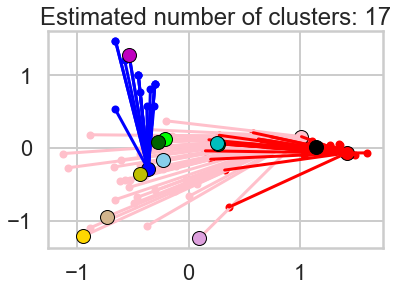

In [36]:
# Example
af = AffinityPropagation(damping = 0.5).fit(x_cols)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
df['cluster'] = labels
n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: {}'.format(n_clusters_))

sil_score = silhouette_score(x_cols, labels, metric='sqeuclidean')
print('Silhouette Score: {}'.format(silhouette_score))



# let's define a matrix with just the columns we need for plotting
afmatrix = df[['Cluster_3','x','y']]



plt.figure(1)
plt.clf()

list_of_colors = ['pink', 'b', 'r','g','y','k','m','c', 'tan', 'gold', 'plum', 'lime', 'darkgreen', 'skyblue']
for k, col in zip(range(n_clusters_), list_of_colors):
    # define the cluster group for the k value
    cluster_group = afmatrix[afmatrix.Cluster_3 == k].reset_index()
    # get the x,y coordinate of the cluster center
    cluster_center = afmatrix.iloc[cluster_centers_indices[k],1:3]
    #plot a data point for each point in the cluster in the specified color and marker
    plt.scatter(cluster_group['x'], cluster_group['y'], color=col, marker='.')
    # plot the cluster center making it larger than the data points
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    # plot a line from the cluster center to the cluster group data point for each point
    for i in range(len(cluster_group)):
        plt.plot([cluster_center[0], cluster_group.loc[i,'x']], [cluster_center[1], cluster_group.loc[i,'y']], col)
        
plt.title('Estimated number of clusters: %d' % n_clusters_)


plt.savefig('AffinityPropagation.png')
plt.show()

##### Spectral Clustering

The present version of SpectralClustering requires the number of clusters to be specified in advance. It works well for a small number of clusters, but is not advised for many clusters. -- see the sklearn documentation

We will tune "n_clusters" parameter of the spectral clustering.

In [37]:
from sklearn.cluster import SpectralClustering

# Hyperparameter Tuning

# Since we've been only using 2≤𝐾≤10, we'll use this range for hyperparameter tuning
n_clusters = list(range(2, 11))

best_score = 0

for k in n_clusters:
    sc = SpectralClustering(n_clusters=k)
    sc_cluster = sc.fit_predict(x_cols)
    sil_avg_score = silhouette_score(x_cols, sc_cluster, random_state = 21)
    
    print("For n_cluster of: {:0.0f}, the silhouette score is: {:0.3f}".format(k, sil_avg_score))
    if sil_avg_score > best_score:
        best_score = sil_avg_score  # Update with the best silhouette score
        optimal_cluster = k
        
print("\nOptimized number of clusters is: {:0.0f}, with a silhouette score of: {:0.3f}".format(optimal_cluster, best_score))
algo_dict["Spectral"] = best_score

For n_cluster of: 2, the silhouette score is: 0.079
For n_cluster of: 3, the silhouette score is: 0.120
For n_cluster of: 4, the silhouette score is: 0.092
For n_cluster of: 5, the silhouette score is: 0.107
For n_cluster of: 6, the silhouette score is: 0.100
For n_cluster of: 7, the silhouette score is: 0.080
For n_cluster of: 8, the silhouette score is: 0.098
For n_cluster of: 9, the silhouette score is: 0.095
For n_cluster of: 10, the silhouette score is: 0.112

Optimized number of clusters is: 3, with a silhouette score of: 0.120


Silhouette Coefficient: 0.1788917578986367


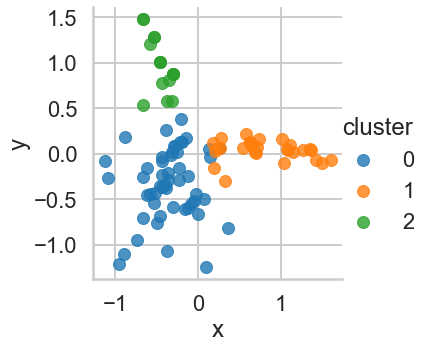

In [38]:
# example
# set n_clusters = 3 to do an "apples to apples" comparison with Kmeans we did above
spectral = SpectralClustering(n_clusters=3, random_state = 5).fit(x_cols)

labels = spectral.labels_
df['cluster'] = labels
sil_score = silhouette_score(x_cols, labels, metric='sqeuclidean')
print('Silhouette Coefficient: {}'.format(sil_score))


sns.lmplot(x='x', y='y', hue='cluster', data=df, fit_reg=False)
plt.savefig('spectral.png')

##### Agglomerative clustering

The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. The linkage criteria determines the metric used for the merge strategy -- see the sklearn documentation:

Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
Complete(Maximum) linkage minimizes the maximum distance between observations of pairs of clusters.
Average linkage minimizes the average of the distances between all observations of pairs of clusters.
Single linkage minimizes the distance between the closest observations of pairs of clusters.
We will tune the "linkage" parameter of the agglomerative clustering. The n_clusters is another parameter needs to be set in advance, so we will set it to 3, as determined from the earliear examples.

In [39]:
from sklearn.cluster import AgglomerativeClustering

# Hyperparameter Tuning
merge_strategy = ['ward', 'complete', 'average', 'single']

# Use n_clusters = 3 for agglomerative clustering 

best_score = 0

for i in range(len(merge_strategy)):
    linkage = merge_strategy[i]  # define the strategy
    
    ac = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    ac_cluster = ac.fit_predict(x_cols)
    sil_avg_score = silhouette_score(x_cols, ac_cluster, random_state = 21)
    
    print("For k=3 and linkage method: '{}', the silhouette score is: {:0.3f}".format(linkage, sil_avg_score))
    if sil_avg_score > best_score:
        best_score = sil_avg_score  # Update with the best silhouette score
        optimal_strategy = linkage
        
print("\nOptimized merge strategy is: '{}', with a silhouette score of: {:0.3f}".format(optimal_strategy, best_score))
algo_dict["Agglomerative"] = best_score

For k=3 and linkage method: 'ward', the silhouette score is: 0.119
For k=3 and linkage method: 'complete', the silhouette score is: 0.190
For k=3 and linkage method: 'average', the silhouette score is: 0.150
For k=3 and linkage method: 'single', the silhouette score is: 0.213

Optimized merge strategy is: 'single', with a silhouette score of: 0.213


Silhouette Coefficient: 0.17838532536507906


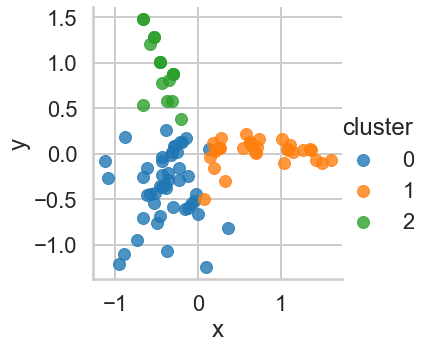

In [40]:
# example
agc = AgglomerativeClustering(n_clusters = 3, linkage='ward').fit(x_cols)
labels= agc.labels_
df['cluster'] = labels
sil_score = silhouette_score(x_cols, labels, metric='sqeuclidean')
print('Silhouette Coefficient: {}'.format(sil_score))




sns.lmplot(x='x', y='y', hue='cluster', data=df, fit_reg=False) 
plt.savefig('agglomerate.png')


##### DBSCAN


There are two parameters to the algorithm, min_samples and eps, which define formally what we mean when we say dense. Higher min_samples or lower eps indicate higher density necessary to form a cluster. -- see the sklearn documentation

While the parameter min_samples primarily controls how tolerant the algorithm is towards noise (on noisy and large data sets it may be desiable to increase this parameter), the parameter eps is crucial to choose appropriately for the data set and distance function and usually cannot be left at the default value. It controls the local neighborhood of the points. When chosen too small, most data will not be clustered at all (and labeled as -1 for “noise”). When chosen too large, it causes close clusters to be merged into one cluster, and eventually the entire data set to be returned as a single cluster.

The "eps" parameter will be tuned for the DBSCAN algorithm.

In [41]:
from sklearn.cluster import DBSCAN

# Hyperparameter Tuning
eps_list = np.linspace(0.1, 2 , 10, endpoint=False) # # Returns 10 values for eps

# Tune min_samples for DBSCAN 
# min_samples = [1, 2, 3]

best_score = 0

for s in eps_list:
    
    db = DBSCAN(eps=s, min_samples=3)
    db_cluster = db.fit_predict(x_cols)
    sil_avg_score = silhouette_score(x_cols, db_cluster, random_state = 21)
    
    print("For eps: '{:0.2f}', the silhouette score is: {:0.3f}".format(s, sil_avg_score))
    if sil_avg_score > best_score:
        best_score = sil_avg_score  # Update with the best silhouette score
        optimal_eps = s
        
print("\nBest eps value is: '{:0.2f}', with a silhouette score of: {:0.3f}".format(optimal_eps, best_score))
algo_dict["DBSCAN"] = best_score

For eps: '0.10', the silhouette score is: -0.103
For eps: '0.29', the silhouette score is: -0.103
For eps: '0.48', the silhouette score is: -0.103
For eps: '0.67', the silhouette score is: -0.103
For eps: '0.86', the silhouette score is: -0.103
For eps: '1.05', the silhouette score is: 0.039
For eps: '1.24', the silhouette score is: 0.039
For eps: '1.43', the silhouette score is: 0.135
For eps: '1.62', the silhouette score is: 0.135
For eps: '1.81', the silhouette score is: 0.180

Best eps value is: '1.81', with a silhouette score of: 0.180


Silhouette Coefficient: 0.03193540292911213


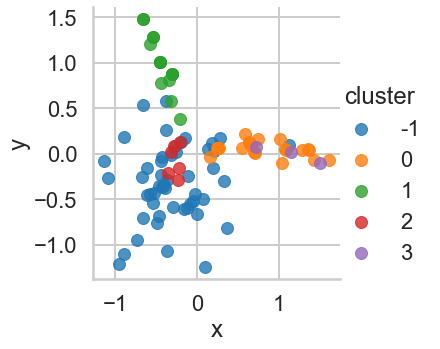

In [42]:
# example
dbscan = DBSCAN(min_samples=3, eps=1.4).fit(x_cols)
labels = dbscan.labels_
df['cluster'] = labels
sil_score = silhouette_score(x_cols, labels, metric='sqeuclidean')
print('Silhouette Coefficient: {}'.format(sil_score))


sns.lmplot(x='x', y='y', hue='cluster', data=df, fit_reg=False)
plt.savefig('DBSCAN.png')

Now, we have the silhouette scores of the algorithms above. Let's create a dataframe from the "algo_dict" dictionary that contains the scores.

In [43]:
# Make a dataframe from the dictionary: 
algo_evaluation = pd.DataFrame(algo_dict.items(), columns=['Algorithm', 'Best Silhouette Scores']) 
algo_evaluation.set_index('Algorithm', inplace=True)
algo_evaluation

,Best Silhouette Scores
Algorithm,
Affinity,0.127676
Spectral,0.120432
Agglomerative,0.213099
DBSCAN,0.180468
